# Kaggle
## Competição DSA de Machine Learning - Dezembro 2019

Versão 1.0.1: LB = ??? CV = 0.444957
- modelo: Catboost (com algumas otimizações)
- features engineering: gerado através do Auto_ViML

## 1. Importando as bibliotecas

In [1]:
# Importar os principais pacotes
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

import time
import gc

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Variavel para controlar o treinamento no Kaggle
TRAIN_OFFLINE = True

In [18]:
# Importa os pacotes de algoritmos
from catboost import Pool, CatBoostClassifier, cv

# Importa pacotes do sklearn
from sklearn.metrics import log_loss, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split


## 2. Carregando os dados de treino e teste

In [3]:
def read_data():
    
    if TRAIN_OFFLINE:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('../dataset/dataset_treino_modificado.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_teste.csv....')
        test = pd.read_csv('../dataset/dataset_teste_modificado.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
        
    else:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_treino.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_treino.csv....')
        test = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_teste.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
    
    return train, test

In [4]:
# Leitura dos dados
train, test = read_data()

Carregando arquivo dataset_treino.csv....
dataset_treino.csv tem 114321 linhas and 44 colunas
Carregando arquivo dataset_teste.csv....
dataset_teste.csv tem 114393 linhas and 51 colunas


In [5]:
train.head()

,v31,v129,v50,v110,v66,v47,v38,v113,v56,v79,v24,v71,v74,v101,v3,v62,v30,v85,v72,v67,v100,v94,v84,v111,v95,v106,v108,v22,v125,v112,v52,v91,v107,v10_bin,v14_bin,v26_bin,v28_bin,v34_bin,v46_bin,v55_bin,v57_bin,v58_bin,v65_bin,target
0,0,0,0.1113,0,0,0,0,0,0,0,0,0,0,0.3862,0,1,0,0.2697,1,0.5990,0.1417,0.2817,0.1394,0.3382,0.2129,0.4952,0.1311,0,0,0,0,0,0,49,45,122,175,141,251,138,9,106,128,0
1,0,0,0.1634,0,1,1,0,1,1,1,1,1,0,0.0000,0,1,1,0.0000,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,0,1,0,0,61,35,0,0,175,0,0,0,0,0,1
2,0,0,0.1464,0,0,2,0,0,2,2,2,1,0,0.2334,0,1,-1,0.3286,1,0.4413,0.7646,0.2397,0.1727,0.3401,0.1635,0.4079,0.1351,2,2,1,0,0,0,61,58,30,175,62,124,138,21,54,37,1
3,0,0,0.0534,0,2,1,0,0,-1,3,1,1,0,0.0000,0,2,-1,0.0000,2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3,3,2,2,1,1,38,43,0,0,62,0,0,0,0,0,0
4,1,0,0.1714,1,1,3,6,-1,3,4,0,1,1,0.3983,0,0,-1,0.1146,6,0.5069,0.9732,0.1976,0.1287,0.2367,0.1700,0.6123,0.1325,4,4,3,3,0,0,55,137,54,69,120,15,32,61,22,151,1


In [6]:
test.head()

,v31,v129,v50,v110,v66,v47,v38,v113,v56,v79,v24,v71,v74,v101,v3,v62,v30,v85,v72,v67,v100,v94,v84,v111,v95,v106,v108,v22,v125,v112,v52,v91,v107,v10_bin,v14_bin,v26_bin,v28_bin,v34_bin,v46_bin,v55_bin,v57_bin,v58_bin,v65_bin,target_Logistic Regression_predictions,target_Linear Discriminant_predictions,target_Naive Bayes_predictions,target_Bagging_predictions,target_CatBoost_predictions,Class_proba_0,Class_proba_1,target_Ensembled_predictions
0,0,0,0.0533,0,2,2,0,-1,2,2,1,1,0,0.2470,0,1,-1,0.1362,1,0.4300,0.9861,0.1995,0.0901,0.2176,0.1748,0.6042,0.1192,10794,19,7,7,3,3,49,100,30,43,62,16,52,9,10,129,1,1,0,0,0,0.7078,0.2922,0
1,0,0,0.0965,1,1,3,4,-1,4,6,3,1,0,0.0000,0,1,4,0.0000,5,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,113,53,14,10,2,2,48,44,0,0,212,0,0,0,0,0,1,1,1,1,1,0.1193,0.8807,1
2,0,0,0.0877,0,1,1,0,1,28,3,0,1,0,0.3588,0,1,1,0.1362,1,0.4805,0.9905,0.2080,0.0847,0.1960,0.1594,0.6070,0.1042,18210,66,17,10,2,2,55,158,163,16,158,2,21,141,0,129,1,1,1,1,1,0.2935,0.7065,1
3,0,0,0.0927,0,0,1,0,0,0,3,1,1,0,0.2204,0,1,5,0.3333,1,0.4477,0.0531,0.3033,0.2486,0.2349,0.2006,0.3313,0.1758,2444,65,5,10,3,3,55,38,49,175,114,207,182,95,131,21,1,1,1,1,1,0.3575,0.6425,1
4,0,0,0.1187,0,0,1,0,13,-1,3,1,1,0,0.3622,0,2,1,0.0930,2,0.4985,0.9632,0.2441,0.0734,0.1347,0.1408,0.7460,0.1651,7527,36,16,8,3,3,38,45,153,152,69,27,21,141,36,170,1,1,1,1,1,0.2675,0.7325,1


## 3. Feature Engineering

In [7]:
test = test[test.columns[:-8]]

In [8]:
df = train.append(test)

In [9]:
df.head()

,target,v100,v101,v106,v107,v108,v10_bin,v110,v111,v112,v113,v125,v129,v14_bin,v22,v24,v26_bin,v28_bin,v3,v30,v31,v34_bin,v38,v46_bin,v47,v50,v52,v55_bin,v56,v57_bin,v58_bin,v62,v65_bin,v66,v67,v71,v72,v74,v79,v84,v85,v91,v94,v95
0,0.0000,0.1417,0.3862,0.4952,0,0.1311,49,0,0.3382,0,0,0,0,45,0,0,122,175,0,0,0,141,0,251,0,0.1113,0,138,0,9,106,1,128,0,0.5990,0,1,0,0,0.1394,0.2697,0,0.2817,0.2129
1,1.0000,0.0000,0.0000,0.0000,0,0.0000,61,0,0.0000,0,1,1,0,35,1,1,0,0,0,1,0,175,0,0,1,0.1634,1,0,1,0,0,1,0,1,0.0000,1,1,0,1,0.0000,0.0000,0,0.0000,0.0000
2,1.0000,0.7646,0.2334,0.4079,0,0.1351,61,0,0.3401,1,0,2,0,58,2,2,30,175,0,-1,0,62,0,124,2,0.1464,0,138,2,21,54,1,37,0,0.4413,1,1,0,2,0.1727,0.3286,0,0.2397,0.1635
3,0.0000,0.0000,0.0000,0.0000,1,0.0000,38,0,0.0000,2,0,3,0,43,3,1,0,0,0,-1,0,62,0,0,1,0.0534,2,0,-1,0,0,2,0,2,0.0000,1,2,0,3,0.0000,0.0000,1,0.0000,0.0000
4,1.0000,0.9732,0.3983,0.6123,0,0.1325,55,1,0.2367,3,-1,4,0,137,4,0,54,69,0,-1,1,120,6,15,3,0.1714,3,32,3,61,22,0,151,1,0.5069,1,6,1,4,0.1287,0.1146,0,0.1976,0.1700


## 4. Criar e avaliar alguns algoritmos de Machine Learning

## 4.1. Algoritmo Catboost


In [22]:
#Checking for any categorical features
cate_features_index = np.where(df.dtypes == 'object')[0]
cate_features_index

array([], dtype=int64)

In [10]:
# Separar o dataset de treino e teste
treino = df[df['target'].notnull()]
teste  = df[df['target'].isnull()]

# Separando features preditoras e target
#X_ = treino.drop(['ID','target'], axis=1)
X = treino.drop(['target'], axis=1)
y = treino['target']

# Padronizando os dados de treino
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [41]:
#make the x for train and test (also called validation data) 
xtrain,xtest,ytrain,ytest = train_test_split(X,y,train_size=0.99,random_state=1236)

In [42]:
#let us make the catboost model, use_best_model params will make the model prevent overfitting
model = CatBoostClassifier(iterations=1500, 
                           learning_rate=0.01, 
                           l2_leaf_reg=3.5, 
                           depth=8, 
                           rsm=0.98, 
                           loss_function= 'Logloss', 
                           eval_metric='AUC',
                           use_best_model=True,
                           random_seed=42)

In [43]:
#now just to make the model to fit the data
model.fit(xtrain,ytrain,cat_features=cate_features_index,eval_set=(xtest,ytest))

0:	test: 0.6911805	best: 0.6911805 (0)	total: 31.2ms	remaining: 46.8s
1:	test: 0.7034173	best: 0.7034173 (1)	total: 58.5ms	remaining: 43.8s
2:	test: 0.7172447	best: 0.7172447 (2)	total: 82.9ms	remaining: 41.4s
3:	test: 0.7225893	best: 0.7225893 (3)	total: 108ms	remaining: 40.3s
4:	test: 0.7235901	best: 0.7235901 (4)	total: 129ms	remaining: 38.7s
5:	test: 0.7247898	best: 0.7247898 (5)	total: 153ms	remaining: 38.1s
6:	test: 0.7242918	best: 0.7247898 (5)	total: 175ms	remaining: 37.3s
7:	test: 0.7245120	best: 0.7247898 (5)	total: 196ms	remaining: 36.6s
8:	test: 0.7251475	best: 0.7251475 (8)	total: 217ms	remaining: 36s
9:	test: 0.7243843	best: 0.7251475 (8)	total: 239ms	remaining: 35.6s
10:	test: 0.7241485	best: 0.7251475 (8)	total: 251ms	remaining: 34s
11:	test: 0.7248848	best: 0.7251475 (8)	total: 271ms	remaining: 33.7s
12:	test: 0.7256275	best: 0.7256275 (12)	total: 292ms	remaining: 33.4s
13:	test: 0.7261683	best: 0.7261683 (13)	total: 312ms	remaining: 33.1s
14:	test: 0.7264594	best: 0.7

117:	test: 0.7326951	best: 0.7327513 (115)	total: 2.32s	remaining: 27.2s
118:	test: 0.7328014	best: 0.7328014 (118)	total: 2.34s	remaining: 27.2s
119:	test: 0.7328561	best: 0.7328561 (119)	total: 2.36s	remaining: 27.2s
120:	test: 0.7329198	best: 0.7329198 (120)	total: 2.38s	remaining: 27.2s
121:	test: 0.7329686	best: 0.7329686 (121)	total: 2.4s	remaining: 27.1s
122:	test: 0.7329987	best: 0.7329987 (122)	total: 2.42s	remaining: 27.1s
123:	test: 0.7330059	best: 0.7330059 (123)	total: 2.44s	remaining: 27.1s
124:	test: 0.7330328	best: 0.7330328 (124)	total: 2.46s	remaining: 27s
125:	test: 0.7330824	best: 0.7330824 (125)	total: 2.48s	remaining: 27s
126:	test: 0.7331140	best: 0.7331140 (126)	total: 2.49s	remaining: 27s
127:	test: 0.7331779	best: 0.7331779 (127)	total: 2.51s	remaining: 26.9s
128:	test: 0.7331981	best: 0.7331981 (128)	total: 2.54s	remaining: 27s
129:	test: 0.7332773	best: 0.7332773 (129)	total: 2.56s	remaining: 27s
130:	test: 0.7333098	best: 0.7333098 (130)	total: 2.58s	remain

239:	test: 0.7391698	best: 0.7391698 (239)	total: 4.66s	remaining: 24.5s
240:	test: 0.7392355	best: 0.7392355 (240)	total: 4.68s	remaining: 24.4s
241:	test: 0.7392829	best: 0.7392829 (241)	total: 4.7s	remaining: 24.4s
242:	test: 0.7393800	best: 0.7393800 (242)	total: 4.72s	remaining: 24.4s
243:	test: 0.7393840	best: 0.7393840 (243)	total: 4.74s	remaining: 24.4s
244:	test: 0.7394524	best: 0.7394524 (244)	total: 4.75s	remaining: 24.4s
245:	test: 0.7395426	best: 0.7395426 (245)	total: 4.77s	remaining: 24.3s
246:	test: 0.7395398	best: 0.7395426 (245)	total: 4.79s	remaining: 24.3s
247:	test: 0.7395846	best: 0.7395846 (247)	total: 4.81s	remaining: 24.3s
248:	test: 0.7396482	best: 0.7396482 (248)	total: 4.83s	remaining: 24.2s
249:	test: 0.7396863	best: 0.7396863 (249)	total: 4.84s	remaining: 24.2s
250:	test: 0.7397554	best: 0.7397554 (250)	total: 4.87s	remaining: 24.2s
251:	test: 0.7397875	best: 0.7397875 (251)	total: 4.88s	remaining: 24.2s
252:	test: 0.7398435	best: 0.7398435 (252)	total: 4.

357:	test: 0.7433747	best: 0.7433747 (357)	total: 6.94s	remaining: 22.1s
358:	test: 0.7434225	best: 0.7434225 (358)	total: 6.95s	remaining: 22.1s
359:	test: 0.7434370	best: 0.7434370 (359)	total: 6.97s	remaining: 22.1s
360:	test: 0.7434551	best: 0.7434551 (360)	total: 6.99s	remaining: 22.1s
361:	test: 0.7434697	best: 0.7434697 (361)	total: 7.01s	remaining: 22s
362:	test: 0.7435018	best: 0.7435018 (362)	total: 7.03s	remaining: 22s
363:	test: 0.7435207	best: 0.7435207 (363)	total: 7.04s	remaining: 22s
364:	test: 0.7435388	best: 0.7435388 (364)	total: 7.06s	remaining: 22s
365:	test: 0.7435494	best: 0.7435494 (365)	total: 7.08s	remaining: 21.9s
366:	test: 0.7435779	best: 0.7435779 (366)	total: 7.1s	remaining: 21.9s
367:	test: 0.7436121	best: 0.7436121 (367)	total: 7.12s	remaining: 21.9s
368:	test: 0.7436367	best: 0.7436367 (368)	total: 7.14s	remaining: 21.9s
369:	test: 0.7436591	best: 0.7436591 (369)	total: 7.16s	remaining: 21.9s
370:	test: 0.7437010	best: 0.7437010 (370)	total: 7.17s	rema

476:	test: 0.7459422	best: 0.7459432 (475)	total: 9.25s	remaining: 19.8s
477:	test: 0.7459879	best: 0.7459879 (477)	total: 9.27s	remaining: 19.8s
478:	test: 0.7460131	best: 0.7460131 (478)	total: 9.3s	remaining: 19.8s
479:	test: 0.7460186	best: 0.7460186 (479)	total: 9.33s	remaining: 19.8s
480:	test: 0.7460243	best: 0.7460243 (480)	total: 9.36s	remaining: 19.8s
481:	test: 0.7460653	best: 0.7460653 (481)	total: 9.38s	remaining: 19.8s
482:	test: 0.7460602	best: 0.7460653 (481)	total: 9.4s	remaining: 19.8s
483:	test: 0.7460783	best: 0.7460783 (483)	total: 9.42s	remaining: 19.8s
484:	test: 0.7460861	best: 0.7460861 (484)	total: 9.44s	remaining: 19.8s
485:	test: 0.7461152	best: 0.7461152 (485)	total: 9.47s	remaining: 19.8s
486:	test: 0.7461367	best: 0.7461367 (486)	total: 9.48s	remaining: 19.7s
487:	test: 0.7461556	best: 0.7461556 (487)	total: 9.5s	remaining: 19.7s
488:	test: 0.7461587	best: 0.7461587 (488)	total: 9.52s	remaining: 19.7s
489:	test: 0.7461869	best: 0.7461869 (489)	total: 9.54

595:	test: 0.7477953	best: 0.7477953 (595)	total: 11.5s	remaining: 17.5s
596:	test: 0.7477957	best: 0.7477957 (596)	total: 11.5s	remaining: 17.5s
597:	test: 0.7477917	best: 0.7477957 (596)	total: 11.6s	remaining: 17.5s
598:	test: 0.7478000	best: 0.7478000 (598)	total: 11.6s	remaining: 17.4s
599:	test: 0.7478222	best: 0.7478222 (599)	total: 11.6s	remaining: 17.4s
600:	test: 0.7478160	best: 0.7478222 (599)	total: 11.6s	remaining: 17.4s
601:	test: 0.7478065	best: 0.7478222 (599)	total: 11.7s	remaining: 17.4s
602:	test: 0.7478195	best: 0.7478222 (599)	total: 11.7s	remaining: 17.4s
603:	test: 0.7478332	best: 0.7478332 (603)	total: 11.7s	remaining: 17.3s
604:	test: 0.7478480	best: 0.7478480 (604)	total: 11.7s	remaining: 17.3s
605:	test: 0.7478401	best: 0.7478480 (604)	total: 11.7s	remaining: 17.3s
606:	test: 0.7478518	best: 0.7478518 (606)	total: 11.7s	remaining: 17.3s
607:	test: 0.7478611	best: 0.7478611 (607)	total: 11.8s	remaining: 17.3s
608:	test: 0.7478724	best: 0.7478724 (608)	total: 1

713:	test: 0.7491065	best: 0.7491065 (713)	total: 13.8s	remaining: 15.2s
714:	test: 0.7491209	best: 0.7491209 (714)	total: 13.8s	remaining: 15.2s
715:	test: 0.7491418	best: 0.7491418 (715)	total: 13.9s	remaining: 15.2s
716:	test: 0.7491665	best: 0.7491665 (716)	total: 13.9s	remaining: 15.2s
717:	test: 0.7491620	best: 0.7491665 (716)	total: 13.9s	remaining: 15.1s
718:	test: 0.7491699	best: 0.7491699 (718)	total: 13.9s	remaining: 15.1s
719:	test: 0.7491869	best: 0.7491869 (719)	total: 13.9s	remaining: 15.1s
720:	test: 0.7491909	best: 0.7491909 (720)	total: 13.9s	remaining: 15.1s
721:	test: 0.7492060	best: 0.7492060 (721)	total: 14s	remaining: 15.1s
722:	test: 0.7492469	best: 0.7492469 (722)	total: 14s	remaining: 15s
723:	test: 0.7492434	best: 0.7492469 (722)	total: 14s	remaining: 15s
724:	test: 0.7492429	best: 0.7492469 (722)	total: 14s	remaining: 15s
725:	test: 0.7492519	best: 0.7492519 (725)	total: 14.1s	remaining: 15s
726:	test: 0.7492576	best: 0.7492576 (726)	total: 14.1s	remaining: 

832:	test: 0.7503075	best: 0.7503081 (830)	total: 16.1s	remaining: 12.9s
833:	test: 0.7503094	best: 0.7503094 (833)	total: 16.1s	remaining: 12.9s
834:	test: 0.7503270	best: 0.7503270 (834)	total: 16.2s	remaining: 12.9s
835:	test: 0.7503291	best: 0.7503291 (835)	total: 16.2s	remaining: 12.8s
836:	test: 0.7503552	best: 0.7503552 (836)	total: 16.2s	remaining: 12.8s
837:	test: 0.7503510	best: 0.7503552 (836)	total: 16.2s	remaining: 12.8s
838:	test: 0.7503719	best: 0.7503719 (838)	total: 16.2s	remaining: 12.8s
839:	test: 0.7503734	best: 0.7503734 (839)	total: 16.3s	remaining: 12.8s
840:	test: 0.7503707	best: 0.7503734 (839)	total: 16.3s	remaining: 12.7s
841:	test: 0.7503724	best: 0.7503734 (839)	total: 16.3s	remaining: 12.7s
842:	test: 0.7503864	best: 0.7503864 (842)	total: 16.3s	remaining: 12.7s
843:	test: 0.7503902	best: 0.7503902 (843)	total: 16.3s	remaining: 12.7s
844:	test: 0.7504099	best: 0.7504099 (844)	total: 16.3s	remaining: 12.7s
845:	test: 0.7504272	best: 0.7504272 (845)	total: 1

949:	test: 0.7512598	best: 0.7512598 (949)	total: 18.4s	remaining: 10.7s
950:	test: 0.7512639	best: 0.7512639 (950)	total: 18.4s	remaining: 10.6s
951:	test: 0.7512816	best: 0.7512816 (951)	total: 18.5s	remaining: 10.6s
952:	test: 0.7512850	best: 0.7512850 (952)	total: 18.5s	remaining: 10.6s
953:	test: 0.7512869	best: 0.7512869 (953)	total: 18.5s	remaining: 10.6s
954:	test: 0.7512838	best: 0.7512869 (953)	total: 18.5s	remaining: 10.6s
955:	test: 0.7512959	best: 0.7512959 (955)	total: 18.5s	remaining: 10.5s
956:	test: 0.7513131	best: 0.7513131 (956)	total: 18.5s	remaining: 10.5s
957:	test: 0.7513230	best: 0.7513230 (957)	total: 18.6s	remaining: 10.5s
958:	test: 0.7513364	best: 0.7513364 (958)	total: 18.6s	remaining: 10.5s
959:	test: 0.7513659	best: 0.7513659 (959)	total: 18.6s	remaining: 10.5s
960:	test: 0.7513716	best: 0.7513716 (960)	total: 18.6s	remaining: 10.4s
961:	test: 0.7513727	best: 0.7513727 (961)	total: 18.6s	remaining: 10.4s
962:	test: 0.7513746	best: 0.7513746 (962)	total: 1

1069:	test: 0.7522033	best: 0.7522042 (1067)	total: 20.7s	remaining: 8.32s
1070:	test: 0.7522182	best: 0.7522182 (1070)	total: 20.7s	remaining: 8.3s
1071:	test: 0.7522338	best: 0.7522338 (1071)	total: 20.7s	remaining: 8.28s
1072:	test: 0.7522459	best: 0.7522459 (1072)	total: 20.8s	remaining: 8.26s
1073:	test: 0.7522376	best: 0.7522459 (1072)	total: 20.8s	remaining: 8.24s
1074:	test: 0.7522360	best: 0.7522459 (1072)	total: 20.8s	remaining: 8.22s
1075:	test: 0.7522493	best: 0.7522493 (1075)	total: 20.8s	remaining: 8.2s
1076:	test: 0.7522632	best: 0.7522632 (1076)	total: 20.8s	remaining: 8.18s
1077:	test: 0.7522688	best: 0.7522688 (1077)	total: 20.9s	remaining: 8.16s
1078:	test: 0.7522757	best: 0.7522757 (1078)	total: 20.9s	remaining: 8.14s
1079:	test: 0.7522932	best: 0.7522932 (1079)	total: 20.9s	remaining: 8.12s
1080:	test: 0.7522987	best: 0.7522987 (1080)	total: 20.9s	remaining: 8.1s
1081:	test: 0.7523044	best: 0.7523044 (1081)	total: 20.9s	remaining: 8.08s
1082:	test: 0.7523002	best: 

1187:	test: 0.7530741	best: 0.7530741 (1187)	total: 23s	remaining: 6.04s
1188:	test: 0.7530899	best: 0.7530899 (1188)	total: 23s	remaining: 6.02s
1189:	test: 0.7530894	best: 0.7530899 (1188)	total: 23s	remaining: 6s
1190:	test: 0.7530917	best: 0.7530917 (1190)	total: 23.1s	remaining: 5.98s
1191:	test: 0.7530928	best: 0.7530928 (1191)	total: 23.1s	remaining: 5.96s
1192:	test: 0.7530928	best: 0.7530928 (1191)	total: 23.1s	remaining: 5.94s
1193:	test: 0.7531024	best: 0.7531024 (1193)	total: 23.1s	remaining: 5.92s
1194:	test: 0.7531028	best: 0.7531028 (1194)	total: 23.1s	remaining: 5.91s
1195:	test: 0.7531204	best: 0.7531204 (1195)	total: 23.2s	remaining: 5.88s
1196:	test: 0.7531620	best: 0.7531620 (1196)	total: 23.2s	remaining: 5.87s
1197:	test: 0.7531628	best: 0.7531628 (1197)	total: 23.2s	remaining: 5.85s
1198:	test: 0.7531714	best: 0.7531714 (1198)	total: 23.2s	remaining: 5.83s
1199:	test: 0.7531713	best: 0.7531714 (1198)	total: 23.2s	remaining: 5.81s
1200:	test: 0.7531741	best: 0.7531

1300:	test: 0.7538228	best: 0.7538228 (1300)	total: 25.1s	remaining: 3.84s
1301:	test: 0.7538253	best: 0.7538253 (1301)	total: 25.2s	remaining: 3.83s
1302:	test: 0.7538316	best: 0.7538316 (1302)	total: 25.2s	remaining: 3.81s
1303:	test: 0.7538546	best: 0.7538546 (1303)	total: 25.2s	remaining: 3.79s
1304:	test: 0.7538659	best: 0.7538659 (1304)	total: 25.2s	remaining: 3.77s
1305:	test: 0.7538631	best: 0.7538659 (1304)	total: 25.2s	remaining: 3.75s
1306:	test: 0.7538808	best: 0.7538808 (1306)	total: 25.2s	remaining: 3.73s
1307:	test: 0.7538932	best: 0.7538932 (1307)	total: 25.3s	remaining: 3.71s
1308:	test: 0.7538942	best: 0.7538942 (1308)	total: 25.3s	remaining: 3.69s
1309:	test: 0.7538837	best: 0.7538942 (1308)	total: 25.3s	remaining: 3.67s
1310:	test: 0.7538965	best: 0.7538965 (1310)	total: 25.3s	remaining: 3.65s
1311:	test: 0.7539333	best: 0.7539333 (1311)	total: 25.3s	remaining: 3.63s
1312:	test: 0.7539376	best: 0.7539376 (1312)	total: 25.3s	remaining: 3.61s
1313:	test: 0.7539490	bes

1420:	test: 0.7547049	best: 0.7547049 (1420)	total: 27.4s	remaining: 1.52s
1421:	test: 0.7547265	best: 0.7547265 (1421)	total: 27.4s	remaining: 1.5s
1422:	test: 0.7547328	best: 0.7547328 (1422)	total: 27.4s	remaining: 1.48s
1423:	test: 0.7547479	best: 0.7547479 (1423)	total: 27.4s	remaining: 1.46s
1424:	test: 0.7547525	best: 0.7547525 (1424)	total: 27.5s	remaining: 1.45s
1425:	test: 0.7547637	best: 0.7547637 (1425)	total: 27.5s	remaining: 1.43s
1426:	test: 0.7547693	best: 0.7547693 (1426)	total: 27.5s	remaining: 1.41s
1427:	test: 0.7547664	best: 0.7547693 (1426)	total: 27.5s	remaining: 1.39s
1428:	test: 0.7547802	best: 0.7547802 (1428)	total: 27.5s	remaining: 1.37s
1429:	test: 0.7547911	best: 0.7547911 (1429)	total: 27.6s	remaining: 1.35s
1430:	test: 0.7547953	best: 0.7547953 (1430)	total: 27.6s	remaining: 1.33s
1431:	test: 0.7547994	best: 0.7547994 (1431)	total: 27.6s	remaining: 1.31s
1432:	test: 0.7548060	best: 0.7548060 (1432)	total: 27.6s	remaining: 1.29s
1433:	test: 0.7548136	best

In [44]:
test_data = catboost_pool = Pool(X, y)

# make the prediction using the resulting model
preds_class = model.predict(test_data)
preds_proba = model.predict_proba(test_data)
print("class = ", preds_class)
print("proba = ", preds_proba)
print("Log Loss (Treino): %f" % log_loss(y, preds_proba[:,1]))

class =  [1. 1. 1. ... 1. 1. 1.]
proba =  [[0.33013157 0.66986843]
 [0.05977162 0.94022838]
 [0.29369678 0.70630322]
 ...
 [0.23120341 0.76879659]
 [0.29822265 0.70177735]
 [0.08162977 0.91837023]]
Log Loss (Treino): 0.445226


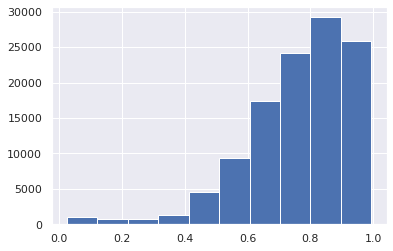

In [45]:
plt.hist(preds_proba[:,1])
plt.show()